<a href="https://colab.research.google.com/github/IAT-ComputationalCreativity-Spring2025/Week11-Genetic-Algorithms/blob/main/DEAP_basics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to DEAP

Documentation: [https://deap.readthedocs.io/en/master/]

## Imports

In [1]:
# Install required libraries
! pip install deap numpy matplotlib

# Import necessary libraries
import random
import numpy as np
import matplotlib.pyplot as plt

from deap import base, creator, tools, algorithms

## DEAP Components

DEAP has several key components:
1. creator - for creating new classes with specific attributes
2. base.Toolbox - for registering operations
3. tools - contains built-in operators for genetic algorithms
4. algorithms - contains ready-to-use evolutionary algorithms

Let's create the following:

- FitnessMax: A fitness class that maximizes a single objective (weight=1.0)
- Individual: A class that inherits from list and has FitnessMax as its fitness attribute

In [2]:
# First, let's define a fitness class that maximizes a single objective
creator.create("FitnessMax", base.Fitness, weights=(1.0,))

# Then, we define an individual type that inherits from list and has our fitness attribute
creator.create("Individual", list, fitness=creator.FitnessMax)

# Initialize the toolbox
toolbox = base.Toolbox()

## Register Operations

In [3]:
# Register a function to create binary genes (0 or 1)
toolbox.register("attr_bool", random.randint, 0, 1)

# Register a function to create individuals (lists of genes)
# tools.initRepeat repeatedly calls attr_bool to create a list
# The third parameter defines the length of the individual (10 genes in this case)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, 10)

# Register a function to create a population (list of individuals)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Create and display a sample individual and population
sample_individual = toolbox.individual()
sample_population = toolbox.population(n=3)

print("Sample individual:", sample_individual)
print("Sample population:", sample_population)

Sample individual: [0, 1, 1, 0, 0, 1, 1, 1, 0, 0]
Sample population: [[0, 0, 0, 1, 1, 1, 0, 1, 0, 0], [0, 1, 0, 0, 1, 0, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1, 1, 1]]


## Evaluation function

In [4]:
# Define a simple evaluation function that counts the number of 1s in the individual
def evalOneMax(individual):
    """Count the number of 1s in the individual (maximize this)"""
    return sum(individual),  # Note the comma - this creates a tuple

# Register the evaluation function in the toolbox
toolbox.register("evaluate", evalOneMax)

# Test the evaluation function
test_individual = creator.Individual([1, 0, 1, 1, 0, 0, 1, 1, 1, 0])
fitness = evalOneMax(test_individual)
print(f"Individual: {test_individual}")
print(f"Fitness: {fitness}")

Individual: [1, 0, 1, 1, 0, 0, 1, 1, 1, 0]
Fitness: (6,)


## Register Genetic Operators

In [5]:
# Register genetic operators in the toolbox

# Crossover operator - two-point crossover
toolbox.register("mate", tools.cxTwoPoint)

# Mutation operator - flip bits with a 10% probability for each bit
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)

# Selection operator - tournament selection with tournament size 3
toolbox.register("select", tools.selTournament, tournsize=3)

# Let's test these operators

# Create two test individuals
ind1 = creator.Individual([1, 1, 0, 0, 1, 1, 0, 0, 1, 1])
ind2 = creator.Individual([0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

print("Before crossover:")
print(f"Individual 1: {ind1}")
print(f"Individual 2: {ind2}")

# Apply crossover
child1, child2 = toolbox.mate(ind1, ind2)
print("\nAfter crossover:")
print(f"Child 1: {child1}")
print(f"Child 2: {child2}")

# Apply mutation to child1
toolbox.mutate(child1)
print("\nAfter mutation:")
print(f"Mutated Child 1: {child1}")

Before crossover:
Individual 1: [1, 1, 0, 0, 1, 1, 0, 0, 1, 1]
Individual 2: [0, 0, 1, 1, 0, 0, 1, 1, 0, 0]

After crossover:
Child 1: [1, 1, 0, 0, 0, 0, 1, 1, 0, 1]
Child 2: [0, 0, 1, 1, 1, 1, 0, 0, 1, 0]

After mutation:
Mutated Child 1: [1, 1, 0, 1, 0, 0, 1, 1, 0, 1]


## Create Initial Population

In [6]:
# Create initial population
population = toolbox.population(n=50)

# Evaluate the entire population
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Get some statistics about the initial population
fits = [ind.fitness.values[0] for ind in population]

print(f"Initial population size: {len(population)}")
print(f"Min fitness: {min(fits)}")
print(f"Max fitness: {max(fits)}")
print(f"Average fitness: {sum(fits) / len(fits)}")

Initial population size: 50
Min fitness: 2.0
Max fitness: 8.0
Average fitness: 4.82


## Run the Algorithm with Statistics

In [7]:
# Set up statistics to track
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", min)
stats.register("max", max)
stats.register("std", np.std)

# Parameters
N_GENS = 40  # Number of generations
P_CROSS = 0.5  # Crossover probability
P_MUTATE = 0.2  # Mutation probability

# Lists to store statistics
gen_numbers = []
max_fitness = []
avg_fitness = []

# Run the algorithm manually so we can track progress
for gen in range(N_GENS):
    # Select the next generation individuals
    offspring = toolbox.select(population, len(population))
    
    # Clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))
    
    # Apply crossover and mutation
    for i in range(1, len(offspring), 2):
        if random.random() < P_CROSS:
            offspring[i-1], offspring[i] = toolbox.mate(offspring[i-1], offspring[i])
            del offspring[i-1].fitness.values
            del offspring[i].fitness.values
    
    for i in range(len(offspring)):
        if random.random() < P_MUTATE:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values
    
    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Replace the old population by the offspring
    population[:] = offspring
    
    # Gather statistics
    fits = [ind.fitness.values[0] for ind in population]
    gen_numbers.append(gen)
    max_fitness.append(max(fits))
    avg_fitness.append(sum(fits) / len(fits))
    
    # Print statistics
    if gen % 5 == 0:
        print(f"Generation {gen}: Max = {max(fits)}, Avg = {sum(fits)/len(fits)}")

# Print final best solution
best_ind = tools.selBest(population, 1)[0]
print("\nBest individual:")
print(f"Genes: {best_ind}")
print(f"Fitness: {best_ind.fitness.values[0]}")

Generation 0: Max = 8.0, Avg = 5.78
Generation 5: Max = 10.0, Avg = 8.7
Generation 10: Max = 10.0, Avg = 9.8
Generation 15: Max = 10.0, Avg = 9.64
Generation 20: Max = 10.0, Avg = 9.88
Generation 25: Max = 10.0, Avg = 9.7
Generation 30: Max = 10.0, Avg = 9.86
Generation 35: Max = 10.0, Avg = 9.8

Best individual:
Genes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fitness: 10.0


## Visualize the Evolution Progress

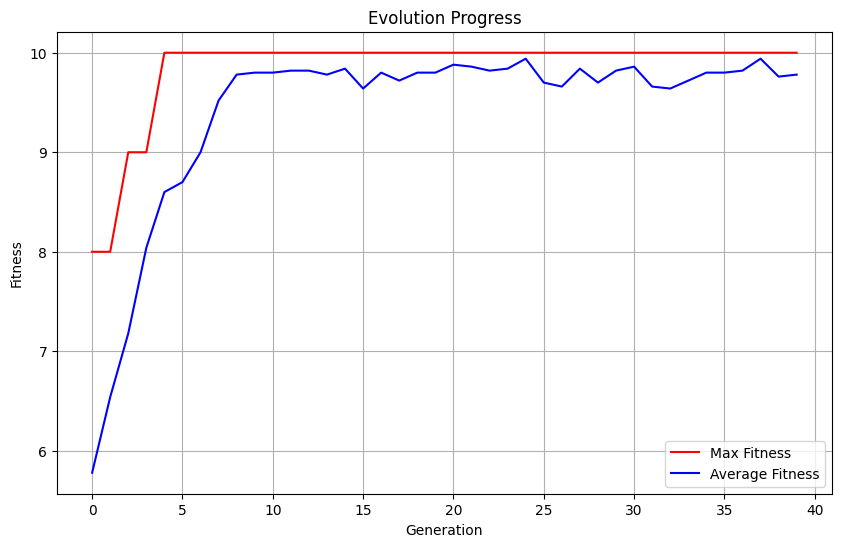

In [8]:
# Plot the evolution progress
plt.figure(figsize=(10, 6))
plt.plot(gen_numbers, max_fitness, 'r-', label='Max Fitness')
plt.plot(gen_numbers, avg_fitness, 'b-', label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Evolution Progress')
plt.legend()
plt.grid(True)
plt.show()

## Using Built-in Algorithms

gen	nevals	avg 	min   	max   	std    
0  	50    	5.06	(2.0,)	(8.0,)	1.48876
1  	27    	6.22	(4.0,)	(9.0,)	1.28515
2  	36    	7.32	(5.0,)	(10.0,)	1.24   
3  	35    	8.34	(5.0,)	(10.0,)	1.12446
4  	25    	9.14	(7.0,)	(10.0,)	0.600333
5  	32    	9.3 	(7.0,)	(10.0,)	0.640312
6  	30    	9.54	(7.0,)	(10.0,)	0.753923
7  	36    	9.66	(6.0,)	(10.0,)	0.815107
8  	28    	9.92	(8.0,)	(10.0,)	0.337046
9  	35    	9.76	(8.0,)	(10.0,)	0.549909
10 	25    	9.78	(7.0,)	(10.0,)	0.641561
11 	26    	9.84	(8.0,)	(10.0,)	0.463033
12 	31    	9.84	(8.0,)	(10.0,)	0.463033
13 	27    	9.84	(8.0,)	(10.0,)	0.463033
14 	25    	9.78	(8.0,)	(10.0,)	0.575847
15 	26    	9.82	(8.0,)	(10.0,)	0.477074
16 	23    	9.9 	(7.0,)	(10.0,)	0.458258
17 	32    	9.78	(8.0,)	(10.0,)	0.501597
18 	27    	9.82	(8.0,)	(10.0,)	0.517301
19 	36    	9.84	(8.0,)	(10.0,)	0.417612
20 	37    	9.66	(7.0,)	(10.0,)	0.79019 
21 	25    	9.94	(9.0,)	(10.0,)	0.237487
22 	33    	9.86	(8.0,)	(10.0,)	0.4005  
23 	21    	9.8 	(7.0,)	(10.0,)	0.6     
24 	31  

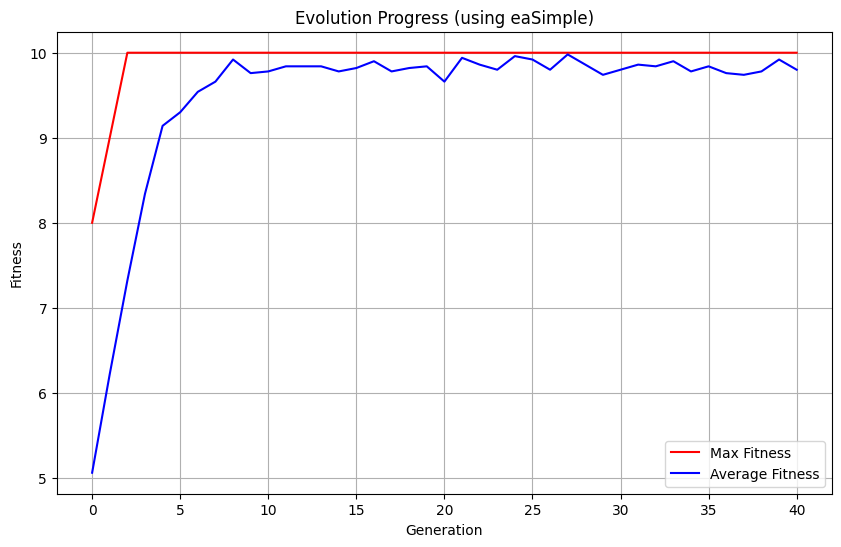


Best individual from eaSimple:
Genes: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Fitness: 10.0


In [9]:
# Instead of manually implementing the evolutionary loop,
# we can use DEAP's built-in algorithms

# Reset the population
population = toolbox.population(n=50)

# Use eaSimple algorithm with the same parameters
result, logbook = algorithms.eaSimple(population, toolbox, 
                                     cxpb=P_CROSS, mutpb=P_MUTATE, 
                                     ngen=N_GENS, stats=stats, 
                                     verbose=True)

# Plot statistics from the logbook
gen = logbook.select("gen")
fit_max = logbook.select("max")
fit_avg = logbook.select("avg")

plt.figure(figsize=(10, 6))
plt.plot(gen, fit_max, 'r-', label='Max Fitness')
plt.plot(gen, fit_avg, 'b-', label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Evolution Progress (using eaSimple)')
plt.legend()
plt.grid(True)
plt.show()

# Print final best solution
best_ind = tools.selBest(result, 1)[0]
print("\nBest individual from eaSimple:")
print(f"Genes: {best_ind}")
print(f"Fitness: {best_ind.fitness.values[0]}")